In [276]:
import numpy as np
import pickle as pkl
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import os

In [277]:
dataset = '08'
angle = 0
algo = 'soenet'
exp_dir = 'kitti/exp_7_nov'

embeddings_file_name = f'/scratch/gurkirat.singh/training_logs/{algo}/{exp_dir}/results/embeddings_{dataset}'
if angle > 0:
    embeddings_file_name += f'_angle_{angle}'
embeddings_file_name += '.pkl'

os.system(f'mkdir -p analysed/{algo}/{exp_dir}')

0

In [278]:
with open(embeddings_file_name, 'rb') as f:
    results = pkl.load(f)

In [279]:
results['embeddings'].shape, results['positions'].shape

((4002, 256), (4002, 3))

In [280]:
def prs(embeddings, positions, positive_range=4):
    assert embeddings.shape[0] == positions.shape[0]
    real_loop = []
    detected_loop = []
    for i in tqdm_notebook(range(1, embeddings.shape[0])):
        for j in range(i):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance <= positive_range:
                real_loop.append(1)
            else:
                real_loop.append(0)
            detected_loop.append(-np.linalg.norm(embeddings[i] - embeddings[j]))
            
    display = PrecisionRecallDisplay.from_predictions(real_loop, detected_loop, name=" ")
    _ = display.ax_.set_title("recision-Recall curve")
    plt.show()
    return precision_recall_curve(real_loop, detected_loop)

  0%|          | 0/4001 [00:00<?, ?it/s]

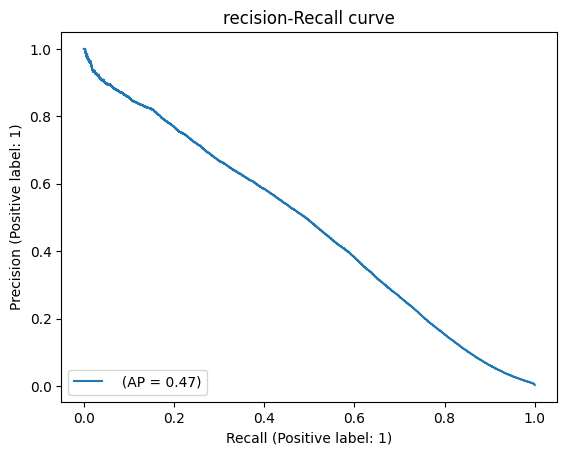

In [281]:
p, r, t = prs(results['embeddings'], results['positions'], 4)
# plt.plot(r,p)

In [282]:
f_score = 2 * p * r / (p + r)
print('max f score: ', f_score.max())
f_score.argmax()

max f score:  0.4958914466484948


3959844

In [283]:
p[f_score.argmax()]

0.4956843403205919

In [284]:
p.mean()

0.027305883009988062

In [285]:
def recall_n(embeddings, positions, positive_range=4, max_n=30):
    max_n = max(int(len(positions) / 100), max_n)
    recalls = np.zeros((max_n,))
    cnt = 0
    for i in tqdm_notebook(range(1,len(embeddings))):
        # print(i)
        poses_tree = KDTree(positions[:i])
        actual_indices = poses_tree.query_radius(positions[i].reshape(1,-1), r=positive_range)
        if len(actual_indices[0]) <= 0:
            continue
        cnt +=1
        embeddings_tree = KDTree(embeddings[:i])
        _, indices = embeddings_tree.query(embeddings[i].reshape(1,-1), k=min(max_n, i))
        none=True
        for rank, index in enumerate(indices[0]):
            pose_distance = np.linalg.norm(positions[i] - positions[index])
            # print(pose_distance)
            if pose_distance <= positive_range:
                # print(i, rank)
                none=False
                recalls[rank:] += 1
                break
                
    recalls /= cnt
    
    return recalls

In [286]:
embs = results['embeddings']
positions = results['positions']

In [287]:
recalls = recall_n(results['embeddings'], results['positions'], max_n=200)

  0%|          | 0/4001 [00:00<?, ?it/s]

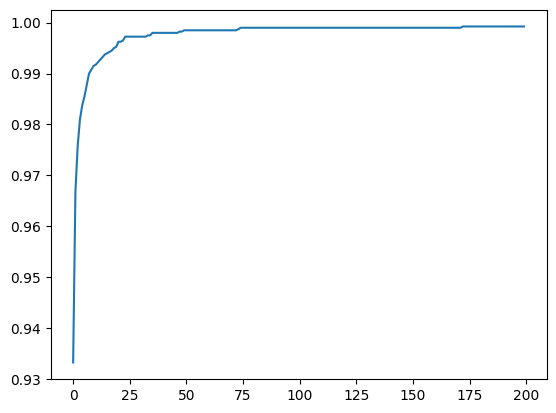

In [288]:
plt.plot(recalls)

In [289]:
recalls[int(0.01*len(results['embeddings']))]

0.9979989994997499

In [290]:
recalls[0]

0.9332166083041521

In [291]:
saved_data = {
    'pr_curve': { 'p': p,'r':r,'t':t},
    'recall@n': recalls
}

In [292]:
with open(f'analysed/{algo}/{exp_dir}/analysed_{dataset}_angle_{angle}.pkl','wb') as f:
    pkl.dump(saved_data, f)

In [293]:
def protocol1(embeddings, positions, positive_range=4):
    real_loop = []
    detected_loop = []
    for i in tqdm_notebook(range(100, embeddings.shape[0])):
        poses_tree = KDTree(positions[:i])
        embeddings_tree = KDTree(embeddings[:i])
        
        actual_indices = poses_tree.query_radius(positions[i].reshape(1,-1), r=positive_range)
        if len(actual_indices[0]) <= 0:
            real_loop.append(0)
        else:
            real_loop.append(1)
        
        embeddings_indices = embeddings_tree.query(embeddings[i].reshape(1,-1),k=1)
        # print(embeddings_indices)
        candidate_index = embeddings_indices[1][0,0]
        # print(candidate_index)
        detected_loop.append(-np.linalg.norm(embeddings[i] - embeddings[candidate_index]))
        
    display = PrecisionRecallDisplay.from_predictions(real_loop, detected_loop, name=" ")
    _ = display.ax_.set_title("Precision-Recall curve")
    plt.show()
    return precision_recall_curve(real_loop, detected_loop)        
        
        


In [294]:
# protocol1(results['embeddings'], results['positions'])